In [1]:
from transformers import BertTokenizer, TFBertForMaskedLM
import numpy as np
import re

In [2]:
import tensorflow as tf


In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForMaskedLM.from_pretrained('bert-base-uncased')

All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [4]:
with open("100sentences.txt", "r") as f:
    data = f.readlines()

In [5]:
print(data)

['Sentence\n', 'Diagnosis You may not know you have atrial fibrillation (AFib).\n', 'The condition may be found when a health checkup is done for another reason.\n', 'To diagnose AFib, the health care provider examines you and asks questions about your medical history and symptoms.\n', 'Tests may be done to look for conditions that can cause irregular heartbeats, such as heart disease or thyroid disease.\n', 'TestsTests to diagnose atrial fibrillation (AFib) may include:\n', 'Blood tests are done to look for health conditions or substances that may affect the heart or heartbeat.\n', 'This quick and painless test measures the electrical activity of the heart.\n', 'Sticky patches called electrodes are placed on the chest and sometimes the arms and legs.\n', 'Wires connect the electrodes to a computer, which prints or displays the test results.\n', 'An ECG can show the heart rhythm and how slow or fast the heart is beating.\n', "It's the main test for diagnosing atrial fibrillation.\n", "

In [6]:
def clean_text(line):
    line = re.sub(r'-+',' ',line)
    line = re.sub(r'[^a-zA-Z, ]+'," ",line)
    line = re.sub(r'[ ]+'," ",line)
    # line += "."
    return line# print(data)

text_lst = []
len_lst = []
for line in data:
    if len(line.split(" ")) >=5:
        line = clean_text(line)
        text_lst.append(line)
        len_lst.append(len(line.split(" ")))

In [7]:
for i in range(3):
    print(text_lst[i])

Diagnosis You may not know you have atrial fibrillation AFib 
The condition may be found when a health checkup is done for another reason 
To diagnose AFib, the health care provider examines you and asks questions about your medical history and symptoms 


In [8]:
print(len_lst)

[11, 15, 19, 21, 9, 19, 13, 16, 15, 17, 10, 11, 15, 22, 8, 10, 12, 12, 9, 15, 14, 20, 15, 12, 14, 19, 10, 19, 9, 13, 15, 18, 7, 7, 6, 9, 15, 11, 18, 12, 7, 9, 8, 23, 16, 16, 9, 12, 16, 16, 18, 19, 30, 8, 25, 9, 8, 12, 9, 24, 11, 22, 7, 22, 8, 13, 14, 16, 20, 7, 16, 12, 22, 8, 14, 13]


In [9]:
inputs = tokenizer(text_lst,max_length=100,truncation=True,padding='max_length',return_tensors='tf')

print(inputs.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [10]:
# print(inputs["input_ids"])

inputs['labels'] = inputs['input_ids']
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [11]:
inp_ids = []
lbs = []
idx = 0
for inp in inputs.input_ids.numpy():
    actual_tokens = list(set(range(100)) - 
                         set(np.where((inp == 101) | (inp == 102) 
                            | (inp == 0))[0].tolist()))
    #We need to select 15% random tokens from the given list
    num_of_token_to_mask = int(len(actual_tokens)*0.15)
    token_to_mask = np.random.choice(np.array(actual_tokens), 
                                     size=num_of_token_to_mask, 
                                     replace=False).tolist()
    #Now we have the indices where we need to mask the tokens
    inp[token_to_mask] = 103
    inp_ids.append(inp)
    idx += 1
inp_ids = tf.convert_to_tensor(inp_ids)
inputs['input_ids'] = inp_ids

In [12]:
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
optimizer = "adam"
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer, loss)
history = model.fit([inputs.input_ids, inputs.attention_mask], inputs.labels, verbose=1, batch_size=8, epochs=10)


Epoch 1/10
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


10/10 [==============================] - 142s 2s/step - loss: 11.7077
Epoch 2/10
10/10 [==============================] - 26s 3s/step - loss: 5.5129
Epoch 3/10
10/10 [==============================] - 27s 3s/step - loss: 2.4159
Epoch 4/10
10/10 [==============================] - 99s 11s/step - loss: 1.6102
Epoch 5/10
10/10 [==============================] - 71s 7s/step - loss: 1.5048
Epoch 6/10
10/10 [==============================] - 118s 11s/step - loss: 1.4379
Epoch 7/10
10/10 [==============================] - 42s 4s/step - loss: 1.4172
Epoch 8/10
10/10 [==============================] - 26s 3s/step - loss: 1.4108
Epoch 9/10
10/10 [==============================] - 64s 7s/step - loss: 1.4020
Epoch

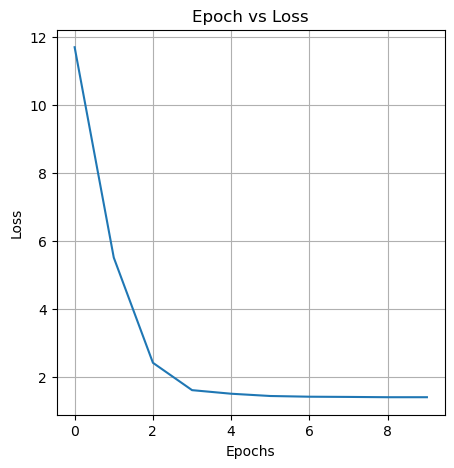

In [13]:
import matplotlib.pyplot as plt


losses = history.history['loss']
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
ax1.plot(range(len(losses)),losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Epoch vs Loss")
plt.grid()
plt.show()

In [14]:
query = "Diagnosis You may not [MASK] you have [MASK] fibrillation (AFib)." #know , atrial
inp = tokenizer(query,return_tensors='tf')
mask_loc = np.where(inp.input_ids.numpy()[0] == 103)[0].tolist()
out = model(inp).logits[0].numpy()
predicted_tokens = np.argmax(out[mask_loc],axis=1).tolist()
tokenizer.decode(predicted_tokens)

'[PAD] [PAD]'

In [15]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18041652468081346454
xla_global_id: -1
]
